In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
matplotlib.rcParams.update({'font.size': 14})

In [3]:
cdfparam = dict({'A':0.4137 , 'tau1':0.9 , 'tau2':0.76, 'b':24 })

In [4]:
def SJK_CDF(t):
    A = cdfparam['A']
    b = cdfparam['b']
    tau1 = cdfparam['tau1']
    tau2 = cdfparam['tau2']
    return A*(1.0-np.exp(-t/tau1) + np.exp((t-b)/tau2))

def Expon_CDF(t):
    lamb = 1/24.0 
    return (1.0 - np.exp(-lamb*t))


In [6]:
def L(t): 
    #Lifetime function , same as expected lifetime 
    #L(24) is MTTF 
    # This can be NEGATIVE? HOW? 
    A = cdfparam['A']
    tau1 = cdfparam['tau1']
    tau2 = cdfparam['tau2']
    b = cdfparam['b']
    return -A*(t+tau1)*np.exp(-t/tau1) + A*(t-tau2)*np.exp((t-b)/tau2)

In [11]:
L(24)

9.61438799997298

$E[T_0] = T  + \int_0^T tf(t) dt$ 

HPDC Expected running time at s: $E[T_s] = T  + \int_s^{s+T} tf(t) dt$

Revised-1 : $E[T_s] = T  + \frac{1}{1-F(s)} \int_s^{s+T} tf(t) dt$

We reuse the Lifetime function, which is  $E[L] = \int_0^L tf(t) dt$

Thus in the HPDC scenario: $E[T_0] = L(T) - L(0)$, and 
 $E[T_s] = L(T+s) - L(s)$
 
 
With the revised-1 running time defintion, we need to scale by $1-F(s)$ and get:
 $E[T_s] = \frac{1}{1-F(s)} [L(T+s) - L(s)]$


 

In [25]:
def sched_decision(s, T):
    # E[T+s] - E[T+0]
    # E[T] = T + \int_0^T tf(t) dt 
    # But, Expected lifetime is also same:, E[L(t)] = \int_0^t tf(t) dt 
    # positive: expected time with old VM is higher, so use a new VM 
    d =  (L(s+T) - L(s)) - (L(T) - L(0))
    return d
    #if d <= 0:
    #    return -1 
    #else:
    #    return 1 

In [14]:
def sched_decision_revised(s, T):
    # E[T+s] - E[T+0]
    # E[T] = T + \int_0^T tf(t) dt 
    # But, Expected lifetime is also same:, E[L(t)] = \int_0^t tf(t) dt 
    # positive: expected time with old VM is higher, so use a new VM 
    T_s = (L(s+T) - L(s))/(1-SJK_CDF(s))
    T_0 = (L(T) - L(0))
    d =  T_s - T_0 
    return d
    #if d <= 0:
    #    return -1 
    #else:
    #    return 1 

In [39]:
def sched_decision_revised2(s, T):
    # E[T+s] - E[T+0]
    # E[T] = T + \int_0^T tf(t) dt 
    # But, Expected lifetime is also same:, E[L(t)] = \int_0^t tf(t) dt 
    # positive: expected time with old VM is higher, so use a new VM 
    scaling = (SJK_CDF(s+T) - SJK_CDF(s))/(SJK_CDF(s+T) - SJK_CDF(s)*SJK_CDF(s+T))
    T_s = (L(s+T) - L(s))*scaling
    T_0 = (L(T) - L(0))
    d =  T_s - T_0 
    return d
    #if d <= 0:
    #    return -1 
    #else:
    #    return 1 

In [36]:
T = 4

[(SJK_CDF(s+T) - SJK_CDF(s))/(SJK_CDF(s+T) - (SJK_CDF(s)*SJK_CDF(s+T))) for s in range(0,20)]


[0.9999999999999885,
 0.4520352259279319,
 0.16990404801538989,
 0.05867954174084614,
 0.01963487002577338,
 0.006498895515047186,
 0.002143252249574266,
 0.0007060190175919128,
 0.00023267665914095345,
 7.740138394951866e-05,
 2.8466330387853857e-05,
 2.0501226790415467e-05,
 4.823834495410086e-05,
 0.00017052790930435177,
 0.0006324500997367865,
 0.0023541911461027075,
 0.008742408104984703,
 0.03213891389635318,
 0.11394062667987494,
 0.35925415066816496]

In [15]:
def bool_decision(s, T):
    d = sched_decision(s, T)
    if d <= 0:
        return -1 
    else:
        return 1 

In [16]:
def bool_decision_revised(s, T):
    d = sched_decision_revised(s, T)
    if d <= 0:
        return -1 
    else:
        return 1 

In [40]:
def bool_decision_revised2(s, T):
    d = sched_decision_revised2(s, T)
    if d <= 0:
        return -1 
    else:
        return 1 

/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator


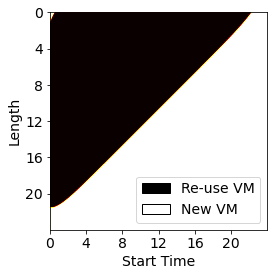

In [42]:
#def plot_3d():
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
#plt.locator_params(nbins=7)

starts  = np.arange(0, 24, 0.01)
lens  = np.arange(0, 24, 0.01)
X, Y = np.meshgrid(starts, lens)
fig = plt.figure()
ax = fig.add_subplot(111) #,projection='3d')
Z = sched_decision_revised2(X, Y)
    #Axes3D.plot_surface(X=X, Y=Y, Z=Z)
Z[Z<0]= -1  #Old VM preferred: Black 
Z[Z>=0] = 1 #New VM preferred : White 
im1 = ax.imshow(Z,cmap='hot') #hot
ax.set_xlabel("Start Time")
ax.set_ylabel("Length")
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))

#ax.tick_params(length=6)
ax.set_xticklabels([0, 0,4,8,12,16,20,24])
ax.set_yticklabels([0, 0,4,8,12,16,20,24])

#ax1_divider = make_axes_locatable(ax)
#cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
#cb1 = fig.colorbar(im1, cax=cax1)
#plt.show()
legend_elements = [Patch(facecolor='black', edgecolor='k',
                         label='Re-use VM'),
                  Patch(facecolor='white', edgecolor='k',
                         label='New VM')]
ax.legend(handles=legend_elements, loc = 'lower right')
plt.savefig("../graphs/tipping-revised2.pdf",bbox_inches='tight')
    #ax.plot_surface(X, Y, Z)

NameError: name 'sched_decision2' is not defined

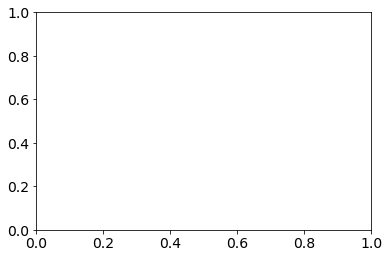

In [38]:
#def plot_3d():
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
#plt.locator_params(nbins=7)

starts  = np.arange(0, 24, 0.01)
lens  = np.arange(0, 24, 0.01)
X, Y = np.meshgrid(starts, lens)
fig = plt.figure()
ax = fig.add_subplot(111) #,projection='3d')
Z = sched_decision_revised2(X, Y)
    #Axes3D.plot_surface(X=X, Y=Y, Z=Z)
Z[Z<0]= -1  #Old VM preferred: Black 
Z[Z>=0] = 1 #New VM preferred : White 
im1 = ax.imshow(Z,cmap='hot') #hot
ax.set_xlabel("Start Time")
ax.set_ylabel("Length")
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))

#ax.tick_params(length=6)
ax.set_xticklabels([0, 0,4,8,12,16,20,24])
ax.set_yticklabels([0, 0,4,8,12,16,20,24])

#ax1_divider = make_axes_locatable(ax)
#cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
#cb1 = fig.colorbar(im1, cax=cax1)
#plt.show()
legend_elements = [Patch(facecolor='black', edgecolor='k',
                         label='Re-use VM'),
                  Patch(facecolor='white', edgecolor='k',
                         label='New VM')]
ax.legend(handles=legend_elements, loc = 'lower right')
plt.savefig("../graphs/tipping-revised2.pdf",bbox_inches='tight')
    #ax.plot_surface(X, Y, Z)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator


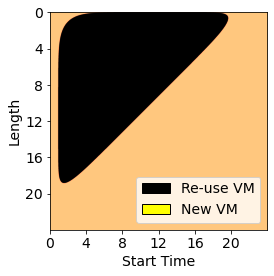

In [33]:
#def plot_3d():
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
#plt.locator_params(nbins=7)

starts  = np.arange(0, 24, 0.01)
lens  = np.arange(0, 24, 0.01)
X, Y = np.meshgrid(starts, lens)
fig = plt.figure()
ax = fig.add_subplot(111) #,projection='3d')
Z = sched_decision_revised(X, Y)
    #Axes3D.plot_surface(X=X, Y=Y, Z=Z)
Z[Z<0]= -1  #Old VM preferred: Black 
Z[Z>=0] = 1 #New VM preferred : White 
im1 = ax.imshow(Z,cmap='copper') #hot
ax.set_xlabel("Start Time")
ax.set_ylabel("Length")
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))

#ax.tick_params(length=6)
ax.set_xticklabels([0, 0,4,8,12,16,20,24])
ax.set_yticklabels([0, 0,4,8,12,16,20,24])

#ax1_divider = make_axes_locatable(ax)
#cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
#cb1 = fig.colorbar(im1, cax=cax1)
#plt.show()
legend_elements = [Patch(facecolor='black', edgecolor='k',
                         label='Re-use VM'),
                  Patch(facecolor='yellow', edgecolor='k',
                         label='New VM')]
ax.legend(handles=legend_elements, loc = 'lower right')
plt.savefig("../graphs/tipping-revised.pdf",bbox_inches='tight')
    #ax.plot_surface(X, Y, Z)

In [83]:
Z[Z<=0]= -1 #negative means fresh VM 

In [84]:
Z[Z>0] = 1

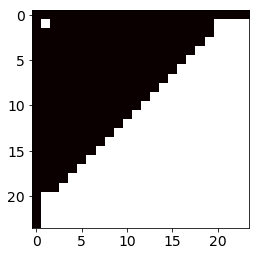

In [85]:
plt.imshow(Z, cmap='hot')

In [74]:
Z

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.],
       [ 0., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.],
       [ 0., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.],
       [ 0., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 0., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 0., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 0., -1., -1., -1., -1., -1., -1.

In [6]:
def job_fail_prob(job_len, start_time):
    p_fail = 0.0
    end_time = job_len + start_time 
    if end_time > 24.3:
        p_fail = 1.0 
        return p_fail 
    p_fail = SJK_CDF(end_time) - SJK_CDF(start_time)
    return p_fail 

In [7]:
def smart_job_fail_prob(job_len, start_time):
    p_fail = 0.0
    end_time = job_len + start_time 
    if end_time > 24.3:
        #start a new one for sure 
        p_fail_new = SJK_CDF(job_len) - SJK_CDF(0)
        return p_fail_new
    else:
        p_fail_old = SJK_CDF(end_time) - SJK_CDF(start_time)
        p_fail_new = SJK_CDF(job_len) - SJK_CDF(0)
        return min(p_fail_new, p_fail_old)

In [8]:
smart_job_fail_prob(8, 16.7)

0.4136429457683769

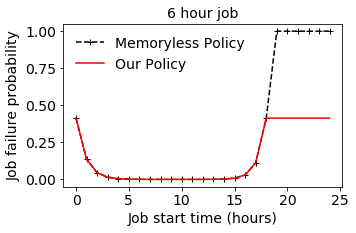

In [9]:
plt.plot([job_fail_prob(6,s) for s in range(0,25)], ls='--', color='k', marker='+', label="Memoryless Policy")
plt.plot([smart_job_fail_prob(6,s) for s in range(0,25)], color='r', label="Our Policy")
plt.legend(loc='best', frameon=False)
plt.xlabel("Job start time (hours)")
plt.ylabel("Job failure probability")
plt.title("6 hour job",fontsize=14)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(5, 3)
#plt.savefig("../graphs/Sched-bathtub.pdf",bbox_inches='tight')

In [19]:
def avg_fail_prob(job_len):
    return np.mean([job_fail_prob(job_len, s) for s in range(0,24)])

def smart_avg_fail_prob(job_len):
    return np.mean([smart_job_fail_prob(job_len, s) for s in range(0,24)])

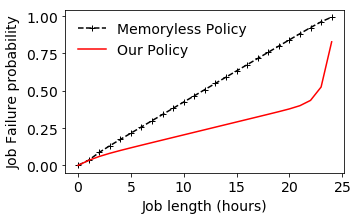

In [54]:
plt.plot([avg_fail_prob(job_len) for job_len in range(0,25)], ls='--', color='k', marker='+' , label="Memoryless Policy")
plt.plot([smart_avg_fail_prob(job_len) for job_len in range(0,25)], color='r', label="Our Policy")
plt.legend(frameon=False)
plt.xlabel("Job length (hours)")
plt.ylabel("Job Failure probability")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(5, 3)
plt.savefig("../graphs/Sched-fail-prob.pdf", bbox_inches='tight')

# Comparing Bathtub vs. Uniform CDF for expected job recomputation time

In [21]:
def exp_wasted(job_len, CDF_type):
    if CDF_type is "SJK":
        fail_prob = job_fail_prob_SJK(job_len, 0)
    else: 
        fail_prob = job_fail_prob_UNIFORM(job_len, 0)

    # We want \sum^joblen {P(x)*x}  
    
    return fail_prob


In [22]:
def job_fail_prob_SJK(job_len, start_time):
    p_fail = 0.0
    end_time = job_len + start_time 
    if end_time > 24.3:
        p_fail = 1.0 
        return p_fail 
    p_fail = SJK_CDF(end_time) - SJK_CDF(start_time)
    return p_fail 

In [23]:
def job_fail_prob_UNIFORM(job_len, start_time):
    p_fail = min(job_len/24.0, 1.0)
    return p_fail 

In [24]:
def wasted_UNIFORM(job_len):
    #Area of the triangle (0,0) (joblen,0) (joblen,CDF(joblen))
    #y = job_len/24.0 
    #return y * 0.5 * job_len 
    return job_len/2.0 #Wasted given there is a single failure 

In [25]:
wasted_UNIFORM(6)

3.0

In [26]:
def func_approx_4_param_expon_exp(t, A, b, tau1, tau2):
    return t*A*((np.exp(-t/tau1)/tau1) + (np.exp((t-b)/tau2))/tau2)    

In [27]:
def expected_paper(t):
    A = cdfparam['A']
    tau1 = cdfparam['tau1']
    tau2 = cdfparam['tau2']
    b = cdfparam['b']
    return -A*(t+tau1)*np.exp(-t/tau1) + A*(t-tau2)*np.exp((t-b)/tau2)

In [28]:
def wasted_SJK(job_len):
    return (expected_paper(job_len) - expected_paper(0))/SJK_CDF(job_len)

In [29]:
wasted_SJK(1)

0.40925827872289094

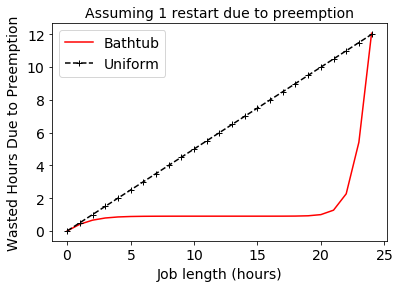

In [59]:
plt.plot([wasted_SJK(jlen) for jlen in range(0,25)], label="Bathtub", color='r')
plt.plot([wasted_UNIFORM(jlen) for jlen in range(0,25)], label="Uniform", ls='--', marker='+',  color='k')
plt.legend()
plt.xlabel("Job length (hours)")
plt.ylabel("Wasted Hours Due to Preemption")
plt.title("Assuming 1 restart due to preemption", fontsize=14)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(6, 4)
plt.savefig("../graphs/uniform-v-bathtub.pdf", bbox_inches='tight')

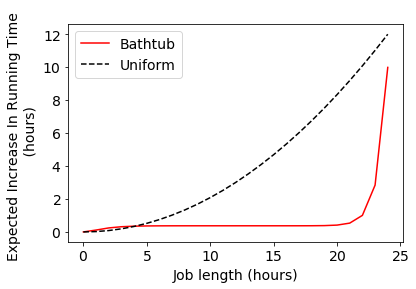

In [60]:
plt.plot([wasted_SJK(jlen)*job_fail_prob_SJK(jlen, 0) for jlen in range(0,25)], label="Bathtub", color='r')
plt.plot([wasted_UNIFORM(jlen)*job_fail_prob_UNIFORM(jlen,0) for jlen in range(0,25)], ls='--', label="Uniform", color='k')
plt.legend()
plt.xlabel("Job length (hours)")
plt.ylabel("Expected Increase In Running Time \n (hours)")
#plt.title("Waste*P(1 failure)")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(6, 4)
plt.savefig("../graphs/uniform-v-bathtub-2.pdf", bbox_inches='tight')